In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
D = 3  # 2-sphere
K = 1  # 1-dimensional manifold
L = 1  # Uniform[-L, L] distribution
B = 4_096  # sampling batch size

In [3]:
LR = 1e-4
EPOCHS = 400
D_ITERATIONS = 10
G_ITERATIONS = 5

In [4]:
source_dist = torch.distributions.uniform.Uniform(-L, L)
target_dist = torch.distributions.normal.Normal(0, 1)

Let's visualize the target distribution samples $\sim \mathcal{U}(S^{D - 1})$.

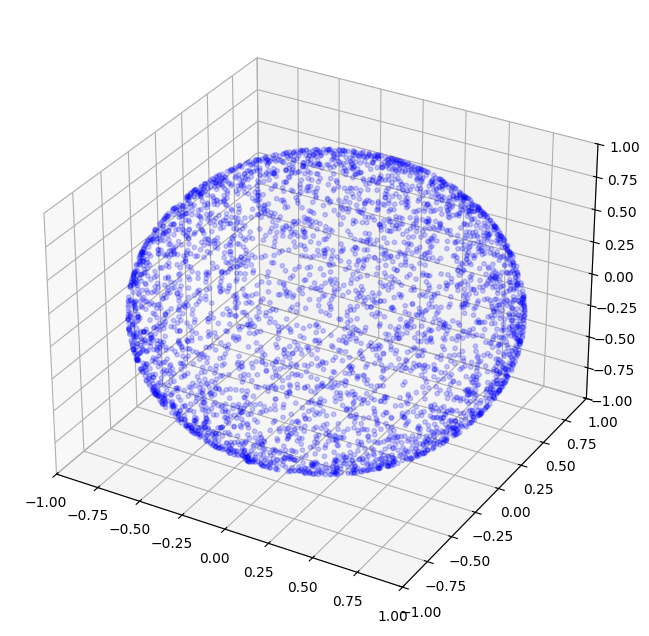

In [5]:
target_test = torch.nn.functional.normalize(target_dist.sample((B, D)), p=2).numpy()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(target_test[:, 0], target_test[:, 1], target_test[:, 2], c='blue', alpha=0.2, s=10)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.show()

## $\phi$ : Vanilla Generative Adversarial Framework

In [6]:
class Phi(torch.nn.Module):
    def __init__(self, omega: float = 1.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.omega = omega
        self.fc1 = torch.nn.Linear(K, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.fc4 = torch.nn.Linear(256, D)

    def forward(self, X):
        X = self.fc1(X)
        X = torch.sin(30 * X)
        X = self.fc2(X)
        X = torch.sin(self.omega * X)
        X = self.fc3(X)
        X = torch.sin(self.omega * X)
        X = self.fc4(X)
        return X

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self, omega=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.omega = omega
        self.fc1 = torch.nn.Linear(D, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.fc4 = torch.nn.Linear(256, 1)

    def forward(self, X):
        X = self.fc1(X)
        X = torch.sin(30 * X)
        X = self.fc2(X)
        X = torch.sin(self.omega * X)
        X = self.fc3(X)
        X = torch.sin(self.omega * X)
        X = self.fc4(X)
        return X

In [8]:
generator = Phi().to('cuda')
critic = Discriminator().to('cuda')
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LR)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=LR)
criterion = torch.nn.BCEWithLogitsLoss()

In [9]:
source_samples = source_dist.sample((B * EPOCHS, K)).to('cuda')
target_samples = torch.nn.functional.normalize(target_dist.sample((B * EPOCHS, D)), p=2).to('cuda')
source_samples.requires_grad = False
target_samples.requires_grad = False

one_labels = torch.ones(B, 1).to('cuda')
zero_labels = torch.zeros(B, 1).to('cuda')

In [ ]:
for epoch in range(EPOCHS):
    start = epoch * B
    end = (epoch + 1) * B
    source_batch = source_samples[start:end]
    target_batch = target_samples[start:end]

    for _ in range(D_ITERATIONS):
        target_fwd = critic(target_batch)
        target_err = criterion(target_fwd, one_labels)

        phi = generator(source_batch)
        source_fwd = critic(phi)
        source_err = criterion(source_fwd, zero_labels)

        critic_loss = target_err + source_err
        critic_loss.backward()
        critic_optimizer.step()
        critic_optimizer.zero_grad()
    for _ in range(G_ITERATIONS):
        phi = generator(source_batch)
        source_fwd = critic(phi)
        gen_loss = criterion(source_fwd, one_labels)
        
        gen_loss.backward()
        gen_optimizer.step()
        gen_optimizer.zero_grad()

    print(f"Epoch {epoch + 1} | Critic Loss: {critic_loss.item():.5f} | Phi Loss: {gen_loss.item():.5f}")

The vanilla GAN for $\phi : \mathcal{U}[-L, L] \rightarrow \mathcal{U}(S^{d-1})$ is nowhere near accurate, even for a trivial problem like $d = 3$.

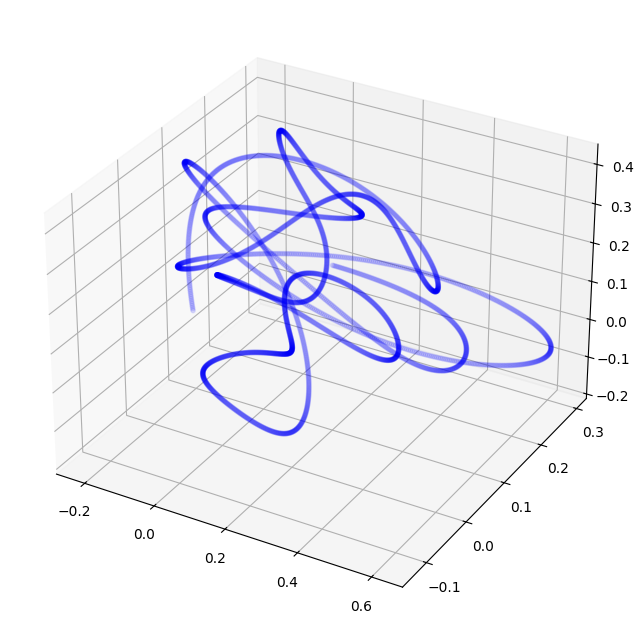

In [11]:
data = torch.linspace(-L, L, B * L).reshape(B * L, 1).to('cuda')
manifold = generator(data).cpu().detach().numpy()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(manifold[:, 0], manifold[:, 1], manifold[:, 2], c='blue', alpha=0.1, s=10)
plt.show()

## $\phi$ : Sliced Wasserstein (SW)

In [12]:
class SlicedWasserstein(torch.nn.Module):
    def __init__(self, slices: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.slices = slices

    def forward(self, source: torch.Tensor, target: torch.Tensor):
        assert source.get_device() == target.get_device()
        device = 'cpu' if source.get_device() == -1 else 'cuda:0'
        
        L = 0
        F_proj = torch.nn.functional.normalize(torch.rand(self.slices, source.shape[1], device=device), p=2)
        D_proj = torch.nn.functional.normalize(torch.rand(self.slices, target.shape[1], device=device), p=2)
        F_sigma = torch.sort(torch.inner(source, F_proj), dim=0).values
        D_sigma = torch.sort(torch.inner(target, D_proj), dim=0).values
        dist = torch.square(torch.norm(D_sigma - F_sigma, p=2, dim=0)) / target.shape[0]
        L += torch.sum(dist)
        return L / self.slices

### SW-Generator (Non-Adversarial)

In the paper *Generative Modeling using the Sliced Wasserstein Distance*, Despande *et al.* propose a Sliced Wasserstein generative model that does not use an adversarial training framework. Instead, the generator network $G$ directly minimizes the Sliced Wasserstein distance between $\mathcal{P}_d$ and $G_{\theta}(\mathcal{P}_z)$ (Section 3).

In [13]:
class Phi(torch.nn.Module):
    def __init__(self, omega: float = 1.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.omega = omega
        self.fc1 = torch.nn.Linear(K, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.fc4 = torch.nn.Linear(256, D)

    def forward(self, X):
        X = self.fc1(X)
        X = torch.sin(30 * X)
        X = self.fc2(X)
        X = torch.sin(self.omega * X)
        X = self.fc3(X)
        X = torch.sin(self.omega * X)
        X = self.fc4(X)
        return X

In [14]:
generator = Phi().to('cuda')
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LR)
criterion = SlicedWasserstein(1000)

In [15]:
source_samples = source_dist.sample((B * EPOCHS, K)).to('cuda')
target_samples = torch.nn.functional.normalize(target_dist.sample((B * EPOCHS, D)), p=2).to('cuda')
source_samples.requires_grad = False
target_samples.requires_grad = False

In [ ]:
for epoch in range(EPOCHS):
    start = epoch * B
    end = (epoch + 1) * B
    
    source_batch = source_samples[start:end]
    target_batch = target_samples[start:end]

    fwd = generator(source_batch)
    loss = criterion(fwd, target_batch)
    loss.backward()
    gen_optimizer.step()
    gen_optimizer.zero_grad()
    
    print(f"Epoch {epoch + 1} | Phi Loss: {loss.item():.5f}")

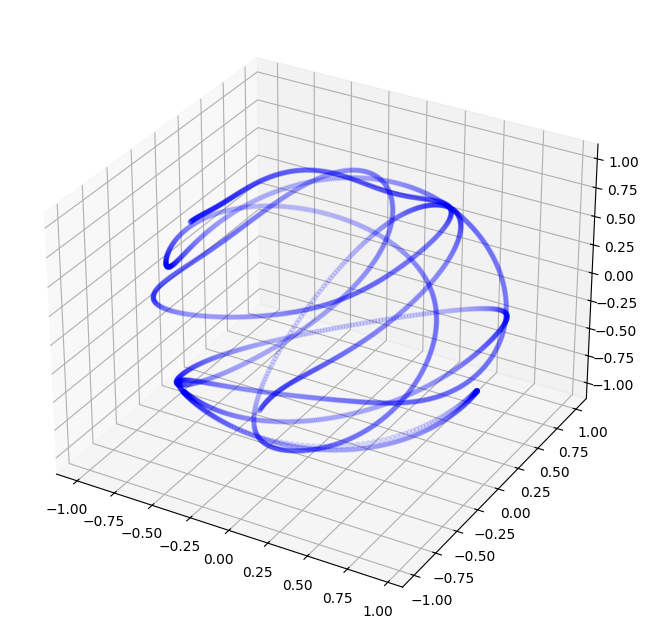

In [17]:
data = torch.linspace(-L, L, B).reshape(B, 1).to('cuda')
manifold = generator(data).cpu().detach().numpy()
manifold = torch.nn.functional.normalize(torch.Tensor(manifold))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(manifold[:, 0], manifold[:, 1], manifold[:, 2], c='blue', alpha=0.1, s=10)
plt.show()

### SW-Generator (Adversarial)

In the same paper, Deshpande *et al.* also propose an adversarial framework for training a Sliced Wasserstein generator, where we use a discriminator in vanilla GAN-fashion. However, the generator has a different optimization problem. We use some latent embedding from the discriminator network $f_{\theta'}$ and would like the generator to match the latent representation of our generated target distribution to that of the actual target distribution. 

If $\theta, \theta'$ are parameters of $D, G$ respectively, and $\mathcal{F}^{\omega}, \mathcal{D}^{\omega}$ are random 1D projections of the source and target samples respectively, the two objectives are:

$$\min_{\theta} \frac{1}{\hat{\Omega}} \sum_{\omega \in \hat{\Omega}} W_2^2(f_{\theta'}(\mathcal{D}^{\omega}), f_{\theta'}(\mathcal{F}^{\omega})(\theta))$$
$$\min_{\theta'} \mathbb{E}[-\log(f'_{\theta'}(\mathcal{D}))] + \mathbb{E}[-\log{1 - f'_{\theta'}(\mathcal{F})}]$$

In [18]:
D_ITERATIONS = 3
G_ITERATIONS = 1

In [19]:
class Phi(torch.nn.Module):
    def __init__(self, omega: int = 30, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.omega = omega
        self.fc1 = torch.nn.Linear(K, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.fc4 = torch.nn.Linear(256, D)

    def forward(self, X):
        X = self.fc1(X)
        X = torch.sin(self.omega * X)
        X = self.fc2(X)
        X = torch.sin(self.omega * X)
        X = self.fc3(X)
        X = torch.sin(self.omega * X)
        X = self.fc4(X)
        return X

In [20]:
class Discriminator(torch.nn.Module):
    def __init__(self, 
                 omega: int = 30, 
                 latent_space: int = 3, 
                 latent_dim: int = 64, 
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert 1 <= latent_space <= 4, "latent_space is out of bounds"
        self.omega = omega
        self.latent_space = latent_space
        self.latent_dim = latent_dim
        
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(D, 256),
            torch.nn.Linear(256, 256),
            torch.nn.Linear(256, 256),
            torch.nn.Linear(256, 1)
        ])
        self.latent_projection = torch.nn.Linear(256, latent_dim, bias=False)

    def forward(self, X):
        latent = None
        for i, layer in enumerate(self.layers):
            X = layer(X)
            if i < len(self.layers) - 1:
                X = torch.sin(self.omega * X if i > 0 else 30 * X)
            if i == self.latent_space - 1:
                latent = self.latent_projection(X)
        return X, latent

In [21]:
generator = Phi().to('cuda')
discriminator = Discriminator(omega=1, latent_space=3, latent_dim=16).to('cuda')

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LR)
discrim_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR)

distribution_criterion = SlicedWasserstein(1000)
discrim_criterion = torch.nn.BCEWithLogitsLoss()

In [22]:
source_samples = source_dist.sample((B * EPOCHS, K)).to('cuda')
target_samples = torch.nn.functional.normalize(target_dist.sample((B * EPOCHS, D)), p=2).to('cuda')
source_samples.requires_grad = False
target_samples.requires_grad = False

In [23]:
one_labels = torch.ones(B, 1).to('cuda')
zero_labels = torch.zeros(B, 1).to('cuda')

In [ ]:
for epoch in range(EPOCHS):
    start = epoch * B
    end = (epoch + 1) * B
    source_batch = source_samples[start:end]
    target_batch = target_samples[start:end]
    
    for _ in range(D_ITERATIONS):
        phi = generator(source_batch)
        source_fwd, _ = discriminator(phi)
        target_fwd, _ = discriminator(target_batch)

        # discrim. optim.
        discrim_loss = discrim_criterion(target_fwd, one_labels) + discrim_criterion(source_fwd, zero_labels)
        discrim_loss.backward()
        discrim_optimizer.step()
        discrim_optimizer.zero_grad()
    for _ in range(G_ITERATIONS):
        phi = generator(source_batch)
        _, latent_phi = discriminator(phi)
        _, latent_target = discriminator(target_batch)

        # gen. optim.
        gen_loss = distribution_criterion(latent_phi, latent_target)
        gen_loss.backward()
        gen_optimizer.step()
        gen_optimizer.zero_grad()

    print(f"Epoch {epoch + 1} | Critic Loss: {discrim_loss.item():.5f} | Phi Loss: {gen_loss.item():.5f}")

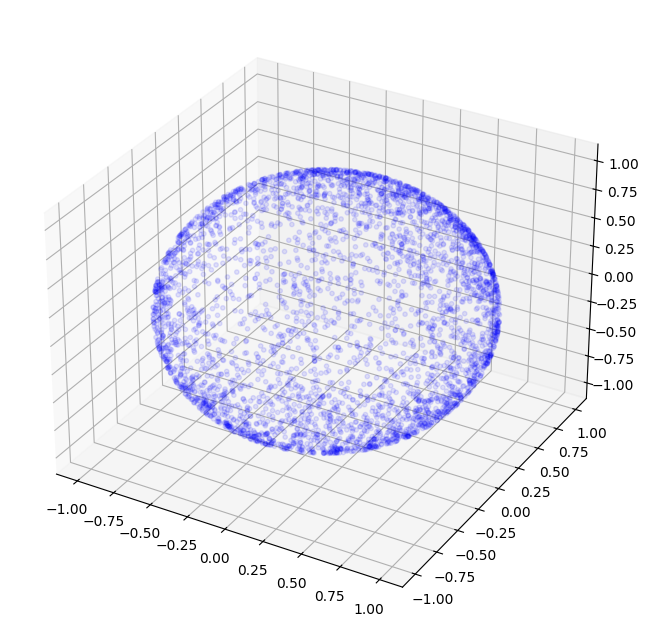

In [25]:
data = source_dist.sample((B, K)).to('cuda')
manifold = generator(data).cpu().detach().numpy()
manifold = torch.nn.functional.normalize(torch.Tensor(manifold))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(manifold[:, 0], manifold[:, 1], manifold[:, 2], c='blue', alpha=0.1, s=10)
plt.show()